In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

◼️1-1. センサは下図のような配置で前腕にしっかりと固着させる。
<center><figure>
    <img src="DSC_0628.JPG" width="300">
    <figcaption>図１．センサの取り付け</figcaption>
</figure></center>  
その後，上腕を鉛直に前腕と手を水平に（肘をほぼ直角に）保ちながら，固定した物体（例えば机の下部分）を全力で上に押すという状態を約３分間続ける。

◼️1-2. 計測データをデータフレーム`df`に読み込む：

In [2]:
df = pd.read_csv('0711TSND121-14011733_2019-07-11_163719.055.csv',
                 names=['item', 'time', 'a_x', 'a_y', 'a_z', 'u_x', 'u_y','u_z'])

In [3]:
df.head()

,item,time,a_x,a_y,a_z,u_x,u_y,u_z
0,ags,59839169,328,-10364,-433,131,255,15
1,ags,59839170,365,-10398,-411,143,249,27
2,ags,59839171,360,-10364,-543,143,242,27
3,ags,59839172,377,-10381,-538,156,255,15
4,ags,59839173,377,-10373,-436,156,261,15


In [4]:
df.tail()

,item,time,a_x,a_y,a_z,u_x,u_y,u_z
202906,ags,60042075,1493,-10249,-326,545,-805,-309
202907,ags,60042076,1510,-10232,-365,539,-830,-309
202908,ags,60042077,1512,-10276,-348,539,-866,-315
202909,ags,60042078,1527,-10332,-324,545,-885,-339
202910,ags,60042079,1537,-10256,-250,539,-897,-345


◼️1-3. 各データの長さ（要素数）は次の通り：

In [5]:
length_of_data = len(df)
print(length_of_data)

202911


◽︎1-3-1 分秒にして：

In [6]:
print(f'{int(length_of_data/1000//60)}分{(length_of_data/1000)%60}秒')

3分22.911秒


◼️1-4. 角速度の各成分を取り出して1D-numpy配列にしておく。ただし，単位を$\mathrm{G}(=9.806\mathrm{m/s^2})$にするため，各配列を10000で割っておく：

In [7]:
a_x = np.array(df['a_x'])/10
a_y = np.array(df['a_y'])/10
a_z = np.array(df['a_z'])/10

> センサで計測された加速度単位は$10^{-1}\mathrm{mG}=\frac{1}{10000}\mathrm{G}$であることに注意。

◼️1-5. 加速度の各成分の時系列グラフ：

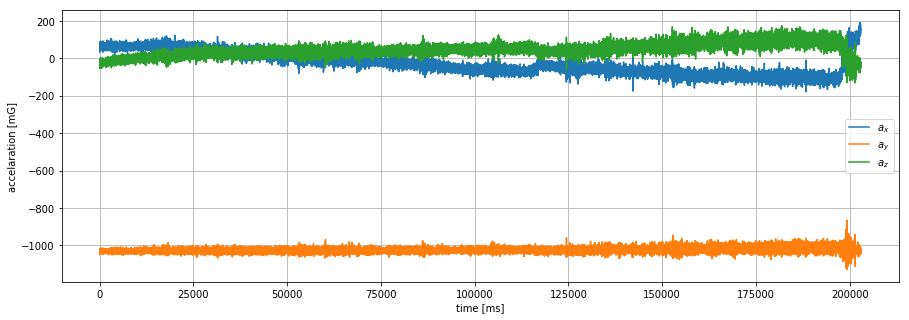

In [8]:
plt.figure(figsize=(15,5))
plt.plot(a_x)
plt.plot(a_y)
plt.plot(a_z)
plt.xlabel('time [ms]')
plt.ylabel('accelaration [mG]')
plt.legend(['$a_x$','$a_y$','$a_z$'])
plt.grid()

> 図１のように，y軸がほぼ鉛直下を向いているので，`a_y`が`-1[G]`付近で微小振動をしていることがわかる。残りの成分は`0[G]`付近で微小振動している。

◼️2-1. 周波数解析をするには，FFT(高速離散フーリエ変換)というアルゴリズム(プログラム)を使うが，この関数はありがたいことに`numpy`ライブラリの`fft`モジュール内にある。`np.fft.fft`という関数だ。マニュアルはセルに`np.fft.fft?`と入力て実行すれば表示される。詳しくはそれを読んでくれ。最も単純な使用方法のみ示しておこう：

***
### 【公式1】NumpyのFFT
サンプルリング周波数$H$Hzの時系列データ配列（1D-numpy配列が望ましい）で，うまく$2^n$（$n$は自然数）個の要素に切り取られた配列を`arr`とする。そのとき，Numpy関数`np.fft.fft`を用いて
```
F_arr = np.fft.fft(arr)/len(arr)
```
として得られた`F_arr`は，`arr`を離散**フーリエ変換**した配列である。ここで右辺の`F_arr`は`arr`と**同じ要素数**`len(arr)`$=2^n$の**複素数**を要素にもつ配列である。  
　　`k = 0, 1, 2, ...`に対して，`F_arr[k]`はデータ`arr`の周波数$\frac{H}{2^n}k$[Hz]のスペクトルとよばれる。なお，`F_arr[0]`は`arr`の平均値（実数）に等しく，直流成分とよばれる。
> 1. 厳密には，この時系列データは周期関数的に変動することが仮定されている。
2. `len(arr)`が$2^n$**でない**ときでも，関数`np.fft.fft`は`arr`のFFTを行う。しかし，より正確かつ高速にFFTを行うには，`len(arr)`$=2^n$であるのが望ましい（でなければならない）。
3. 離散フーリエ変換の定義の違いによって，配列`arr`の要素数`len(arr)`$=2^n$で除さないときもある。Numpyでは`len(arr)`$=2^n$で除さないものを離散フーリエ変換の定義にしていることに注意。
***

## FFTの解説 
　ここではコンピュータで扱う**高速離散フーリエ変換（FFT）**の解説を行うので，時系列データの**サンプリング数（要素数）を特殊なケースの$2^n$にとる**が，一般の離散フーリエ変換（DFT）のサンプリング数は$N(>H)$でよい（$H$はサンプリング周波数）。また，有名なオイラーの公式：$e^{i\theta}=\cos\theta+i\sin\theta$（ここで，$i=\sqrt{-1}$）を用いるが，この公式ぐらい暗記しておいても損はない。また，$e^{i\theta}$の複素共役は，$\cos\theta-i\sin\theta=\cos(-\theta)+i\sin(-\theta)=e^{-i\theta}$であることも付け加えておく。  

　簡単のため，サンプリング開始時刻$t_0$を$0$とし，十分大きな$2^n$（$n$は自然数）をとって，サンプリング周波数$H$のデータの時刻$t$が，等間隔に$t$ $\simeq \{ t_0, t_1, t_2, ...,t_l,..., t_{2^n-1} \}$ $=\{ 0, t_1, t_2, ...,t_l,..., t_{2^n-1} \}$と離散化されているとする。ここで，$\tau$ $:=$ $1/H$ $=t_1-t_0$ $(=t_1-0)$ $=t_2-t_1$ $=...=t_l-t_{l-1}$ $=...=t_{2^n-1}-t_{2^n-2}$とおく。そうすると，実数データ$\xi(t)$も離散化されて，$\xi = \xi(t)$ $\simeq \{\xi(t_0), \xi(t_1), \xi(t_2), ..., \xi(t_l),...,\xi(t_{2^n-1}) \}$ $= \{\xi(0), \xi(\tau), \xi(2\tau), ..., \xi(l\tau),...,\xi((2^n-1)\tau) \}$$=:\{\xi_0, \xi_1, \xi_2, ..., \xi_l,...,\xi_{2^n-1} \}$となる。

　さて，$\xi_l\ \ (l=0,1,2,...,2^{n}-1)$は，

$$
\xi_l=F_0+F_1e^{2\pi i\frac{1l}{2^n}}+F_2e^{2\pi i\frac{2l}{2^n}}+...
+F_ke^{2\pi i\frac{kl}{2^n}}+...+F_{2^n-1}e^{2\pi i\frac{(2^n-1)l}{2^n}}
\tag{1}
=\sum_{k=0}^{2^n-1}F_ke^{2\pi i\frac{kl}{2^n}}
$$

と分解できることがわかっている。ここで，$l$はデータ番号といわれ，時刻$t_0+l\tau$データを表す添字である。この$F_k$を，データ$\xi$の周波数$\frac{H}{2^n}k(=\frac{1}{2^n \tau}k)$のスペクトルといい，$(1)$をフーリエ逆変換という。  
　$F_0$は実数で

$$F_0=\frac{1}{2^n}(\xi_0+\xi_1+\xi_2+...+\xi_{2^{n-1}}+...+\xi_{2^n-1})\\
=\frac{1}{2^n}\sum_{k=0}^{2^n-1}\xi_{k}=:a_0. \tag{2}$$

つまり$F_0=a_0$は全データの平均であり，したがって実数である。  
　$F_0$を除いた$\{F_1, F_2, ..., F_{2^n}\}$のちょうど中間に位置する$F_{2^{n-1}}(=F_{\frac{2^n}{2}})$もまた実数で，

$$F_{2^{n-1}}=\frac{1}{2^n}(\xi_0-\xi_1+\xi_2-\xi_3+...-\xi_{2^{n-1}-1}+\xi_{2^{n-1}}-\xi_{2^{n-1}+1}+...+\xi_{2^n-2}-\xi_{2^n-1})\\
=\frac{1}{2^n}\sum_{k=0}^{2^n-1}(-1)^k\xi_{k}=:a_{2^{n-1}} \tag{3}$$

で与えられる。これをスペクトルのナイキスト成分といい，このときの周波数$\frac{H}{2}=\frac{1}{2\tau}$をナイキスト周波数とよぶ。$(1)$における，$F_{2^{n-1}}=a_{2^{n-1}}$の係数は

$$
e^{2\pi i\frac{2^{n-1}l}{2^n}}=\cos(2\pi \frac{2^{n-1}l}{2^n})+i\sin(2\pi \frac{2^{n-1}l}{2^n})=\cos(\pi l)=(-1)^l \tag{4}
$$

で，これも実数である。 ここで，$\sin(\pi l)=0$に注意せよ。後の便宜のため，$(1)$における$F_{2^{n-1}}$の項を

$$
F_{2^{n-1}}e^{2\pi i\frac{2^{n-1}l}{2^n}}=a_{2^{n-1}}\cos(\pi l)
=a_{2^{n-1}}\cos(2\pi \frac{2^{n-1}l}{2^n})+ib_{2^{n-1}}\sin(2\pi \frac{2^{n-1}l}{2^n}) \tag{5}
$$

としておこう。  
　その他の$F_k$は一般的に複素数なので，

$$F_k =: a_k-ib_k \tag{6}$$ 

とおける。ここで，$a_k,\ b_k$は実数。そうすると，

$$
a_k=\frac{1}{2^n}\sum_{l=0}^{2^n-1} \xi_l \cos(\frac{2\pi kl}{2^n}),\ \ 
b_k=\frac{1}{2^n}\sum_{l=0}^{2^n-1} \xi_l \sin(\frac{2\pi kl}{2^n}) \tag{7}
$$

と書けることがわかっている。$(7)$の２つの式の右辺は気にするな。重要なのは，$0<k<2^{n-1}$で  

$$F_{2^n-k}=\overline{F_k}=a_k+ib_k \tag{8}$$

となることだ（$\cos$が偶関数，$\sin$が奇関数からこのことはほとんど自明）。ここで，記号の上に引いてあるバーは，それの複素共役を示している。$(8)$の関係式は，$(1)$の$a_0,\ a_{2^{n-1}}$の項以外の項の和が実数てあることを保証する（エルミート性）。実際，$(1)$における$F_k$の項と$F_{2^n-k}$の項の和は，

$$
F_{k}e^{2\pi i\frac{kl}{2^n}}+F_{2^n-k}e^{2\pi i\frac{(2^n-k)l}{2^n}}
=F_{k}e^{2\pi i\frac{kl}{2^n}}+\overline{F_k}e^{-2\pi i\frac{kl}{2^n}}
=F_{k}e^{2\pi i\frac{kl}{2^n}}+\overline{F_ke^{2\pi i\frac{kl}{2^n}}}\\
=2a_k\cos(\frac{2\pi kl}{2^n})+2b_k\sin(\frac{2\pi kl}{2^n}) \tag{9}
$$

となり，実数である。  
　$(2),(3),(5),(9)$から，$(1)$は

$$
\xi_l = \xi(l\tau) =\xi(t_l)
\\
$$

$$
=a_0 +
\bigr\{2a_1\cos(\frac{2\pi 1l}{2^n})+2b_1\sin(\frac{2\pi 1l}{2^n})\bigr\}+
\bigr\{2a_2\cos(\frac{2\pi 2l}{2^n})+2b_2\sin(\frac{2\pi 2l}{2^n})\bigr\}+...\\
...+\bigr\{2a_k\cos(\frac{2\pi kl}{2^n})+2b_k\sin(\frac{2\pi kl}{2^n})\bigr\}+
...+\bigr\{2a_{2^{n-1}}\cos(\frac{2\pi 2^{n-1}l}{2^n})+2b_{2^{n-1}}\sin(\frac{2\pi 2^{n-1}l}{2^n})\bigr\}\\
$$

$$
=a_0 +
\bigr\{2a_1\cos(2\pi\frac{H}{2^n}t_l)+2b_1\sin(2\pi\frac{H}{2^n}t_l)\bigr\}+
\bigr\{2a_2\cos(2\pi\frac{2H}{2^n}t_l)+2b_2\sin(2\pi\frac{2H}{2^n}t_l)\bigr\}+...\\
...+\bigr\{2a_k\cos(2\pi\frac{kH}{2^n}t_l)+2b_k\sin(2\pi\frac{kH}{2^n}t_l)\bigr\}+...\\
...+\bigr\{2a_{2^{n-1}}\cos(2\pi\frac{2^{n-1}H}{2^n}t_l)+2b_{2^{n-1}}\sin(2\pi\frac{2^{n-1}H}{2^n}t_l)\bigr\}  \tag{10}
$$

ここで，$H=1/\tau,\ l\tau=t_l\ \rightarrow \ l=Ht_l$を使った。$(10)$より，離散時系列データ$\xi$の任意の時刻$t_l$におけるデータ点$\xi_l$は，サンプリング時間における$\xi$の平均$a_0$(周波数$0$の波)と，$k=1,2,...,2^{n-1}$として，**周波数$\frac{kH}{2^n}$をもつ振幅$2a_k$の余弦波と振幅$2b_k$の正弦波の和として展開できる**ことが解った。  

　このように $F_0,F_1,...,F_{2^{n}-1}$ は，回路またはコンピュータ上で，離散データを$(1)$または$(10)$のように展開したとき，サンプリングデータの全時刻における**平均**と**取り得る周波数の余弦波と正弦波のそれぞれの振幅の$\frac{1}{2}$を複素数を用いて表すことに等しい**。式で書くと（気にするな）：

$$
F_k=\sum_{l=0}^{2^n-1}\xi_le^{2\pi i\frac{k}{2^n}l}=\sum_{l=0}^{2^n-1}\xi_le^{2\pi i\frac{kH}{2^n}l\tau}
\ \ \ (k=0,1,2,...,2^n-1)\\
\mathrm{or}\\
F(\frac{kH}{2^n})=\sum_{l=0}^{2^n-1}\xi(t_l)e^{2\pi i\frac{kH}{2^n}t_l} \tag{11}.
$$

式$(11)$を高速離散フーリエ変換(FFT)という。  
　こうして，【公式１】は，要素数$2^n$のデータ`arr`について，  
 - `F_arr[0]`は`arr`の平均を与える。
 - `F_arr[1]`は周波数$\frac{H}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波の振幅(虚数成分)の$\frac{1}{2}$を与える。
 - `F_arr[2]`は周波数$\frac{2H}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - ...
 - `F_arr[` $k$ `]`は周波数$\frac{kH}{2^n}$の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - ...
 - `F_arr[` $2^{n-1}$ `]`は周波数$\frac{H}{2^{n-1}}$（**ナイキスト周波数**）の`arr`の余弦波(実数成分)の振幅の$\frac{1}{2}$と正弦波(虚数成分)の振幅の$\frac{1}{2}$を与える。
 - これ以降は`F_arr[` $2^{n-1}-1$ `]`, ... , `F_arr[1]`の複素共役である。  

　データの$\{\xi_l\}$の各$F_k$の絶対値の２乗
$$
P_k=\mid F_k \mid ^2 \tag{12}
$$
を周波数$\frac{kl}{2^n}$の**パワー(Power)**という。これは，データ$\{\xi_l\}$をスペクトル分解したときの周波数$\frac{kl}{2^n}$の強度を表す。
 ***

◼️2-2. サンプリング周波数1秒以上の適切なサンプリング時間[ms]を表にしてみよう：

In [9]:
pd.DataFrame({
    'サンプリング周波数[Hz]':np.ones(11)*1000,
    '２の冪($n$)':np.arange(10,21), 
    'サンプリング時間($2^n$)[ms]':2**np.arange(10,21), 
    '周波数間隔[Hz]':1000/2**np.arange(10,21),
    'ナイキスト周波数の１つ前[Hz]':500-1000/2**np.arange(10,21)})

,サンプリング周波数[Hz],２の冪($n$),サンプリング時間($2^n$)[ms],周波数間隔[Hz],ナイキスト周波数の１つ前[Hz]
0,1000.0,10,1024,0.976562,499.023438
1,1000.0,11,2048,0.488281,499.511719
2,1000.0,12,4096,0.244141,499.755859
3,1000.0,13,8192,0.122070,499.877930
4,1000.0,14,16384,0.061035,499.938965
5,1000.0,15,32768,0.030518,499.969482
6,1000.0,16,65536,0.015259,499.984741
7,1000.0,17,131072,0.007629,499.992371
8,1000.0,18,262144,0.003815,499.996185
9,1000.0,19,524288,0.001907,499.998093


> 上の表のどれかのサンプリング時間を使うことにせよ。

◼️2-3. サンプリング周波数1000Hzの与えられた（$2^n$個）のデータ数の取りうる全てのFFT周波数の配列を求める関数`hz_vecor`を定義する：

In [10]:
def hz_vector(arr, samp_hz=1000):
    return samp_hz * np.arange(len(arr))/len(arr)

> オプション`samp_hz=`でサンプリング周波数を変更できる。

◽︎2-3-1. 例えば，サンプリング周波数10Hzの次のような16個の要素を持つ配列`ex_arr`でスペクトル解析を行ってみる：

In [104]:
ex_arr = np.array([-0.78, -1.61, 1.071, 1.28, -0.17, 1.38, 1.29, -1.23, -0.23, 
                   1.23, -0.20, 0.79, 2.76,  0.80, -0.15, 1.36])

◽︎2-3-2. `ex_arr`グラフは，次のようになる：

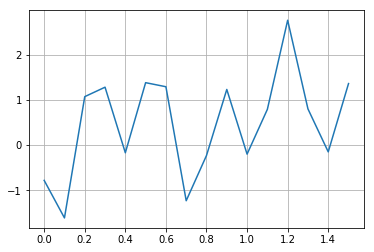

In [105]:
plt.plot(np.arange(16)/10, ex_arr)   #第１引数はサンプリング時刻
plt.grid()

◽︎2-3-3. このときのFFT周波数は：

In [106]:
ex_fft_freq = hz_vector(ex_arr, samp_hz=10)
print(ex_fft_freq)

[0.    0.625 1.25  1.875 2.5   3.125 3.75  4.375 5.    5.625 6.25  6.875
 7.5   8.125 8.75  9.375]


> ナイキスト周波数は5Hzだ。

◽︎2-3-4. `ex_arr`についてFFTをかけると：

In [107]:
F_ex_arr = np.fft.fft(ex_arr)/len(ex_arr)
print(F_ex_arr)

[ 0.4744375 +0.j         -0.05843203+0.13140334j -0.42387378+0.04421289j
 -0.02768879+0.03619817j -0.0269375 +0.025j      -0.02612358+0.64206898j
 -0.02612622+0.01058789j -0.0252556 +0.00477415j -0.0255625 +0.j
 -0.0252556 -0.00477415j -0.02612622-0.01058789j -0.02612358-0.64206898j
 -0.0269375 -0.025j      -0.02768879-0.03619817j -0.42387378-0.04421289j
 -0.05843203-0.13140334j]


> これが，`0, 0.625, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.,　5.625, 6.25, 6.875, 7.5, 8.125, 8.75, 9.375Hz`の`ex_arr`のスペクトルで，`j`は$\sqrt{-1}$だ。

◽︎2-3-5. F_ex_arrにおいて，0Hzとを除いた5Hz(ナイキスト周波数)までの各成分の実数部の２倍がcos波の振幅配列，虚数部の２倍がsin波の振幅配列なので，それぞれを`A_cos`, `A_sin`とすると：

In [108]:
A_cos = np.real(F_ex_arr[1:9]) * 2
A_sin = np.imag(F_ex_arr[1:9]) * 2
print(A_cos)
print(A_sin)

[-0.11686405 -0.84774756 -0.05537758 -0.053875   -0.05224716 -0.05225244
 -0.05051121 -0.051125  ]
[0.26280668 0.08842578 0.07239633 0.05       1.28413795 0.02117578
 0.0095483  0.        ]


◽︎2-3-6. `A_cos`, `A_sin`をプロットすると：

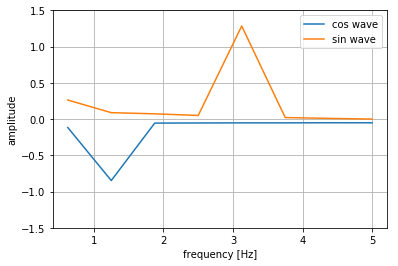

In [109]:
plt.plot(ex_fft_freq[1:9], A_cos)
plt.plot(ex_fft_freq[1:9], A_sin)
plt.legend(['cos wave', 'sin wave'])
plt.ylim([-1.5, 1.5])
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude')
plt.grid()
plt.show()

> cos波の振幅は1.25Hz, sin波の振幅は3.125Hzにピークが現れている。

□2-3-7. `F_ex_arr`のパワー`P_ex_arr`は，

In [115]:
P_ex_arr = np.abs(F_ex_arr)**2
print(P_ex_arr)

[0.22509094 0.02068114 0.18162376 0.00207698 0.00135063 0.41293501
 0.00079468 0.00066064 0.00065344 0.00066064 0.00079468 0.41293501
 0.00135063 0.00207698 0.18162376 0.02068114]


□2-3-8. このパワーのグラフは，次のようになる：

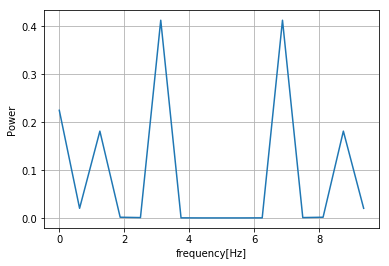

In [116]:
plt.plot(hz_vector(ex_arr, samp_hz=10), P_ex_arr)
plt.xlabel('frequency[Hz]')
plt.ylabel('Power')
plt.grid()

> スペクトル強度のピークは3.125Hz，次のピークは1.25Hzのところにある。
>> ナイキスト周波数以上の周波数帯は無視してよい。

## 以下，口頭で説明する。すまん！

◼️以下のリストをつくる：

In [124]:
l = len(a_x)
lis = []
for i in range(0, l, 10000):  # a_xを10秒ずつずらす
    if i+2**14 > l:
        break
    lis.append([i, i+2**14])
print(lis)

[[0, 16384], [10000, 26384], [20000, 36384], [30000, 46384], [40000, 56384], [50000, 66384], [60000, 76384], [70000, 86384], [80000, 96384], [90000, 106384], [100000, 116384], [110000, 126384], [120000, 136384], [130000, 146384], [140000, 156384], [150000, 166384], [160000, 176384], [170000, 186384], [180000, 196384]]


◼️サンプリング周波数1000Hzのサンプリング数16384のFFT周波数配列：

In [128]:
freq_arr = hz_vector(a_y[0:16384])
print(freq_arr)

[0.00000000e+00 6.10351562e-02 1.22070312e-01 ... 9.99816895e+02
 9.99877930e+02 9.99938965e+02]


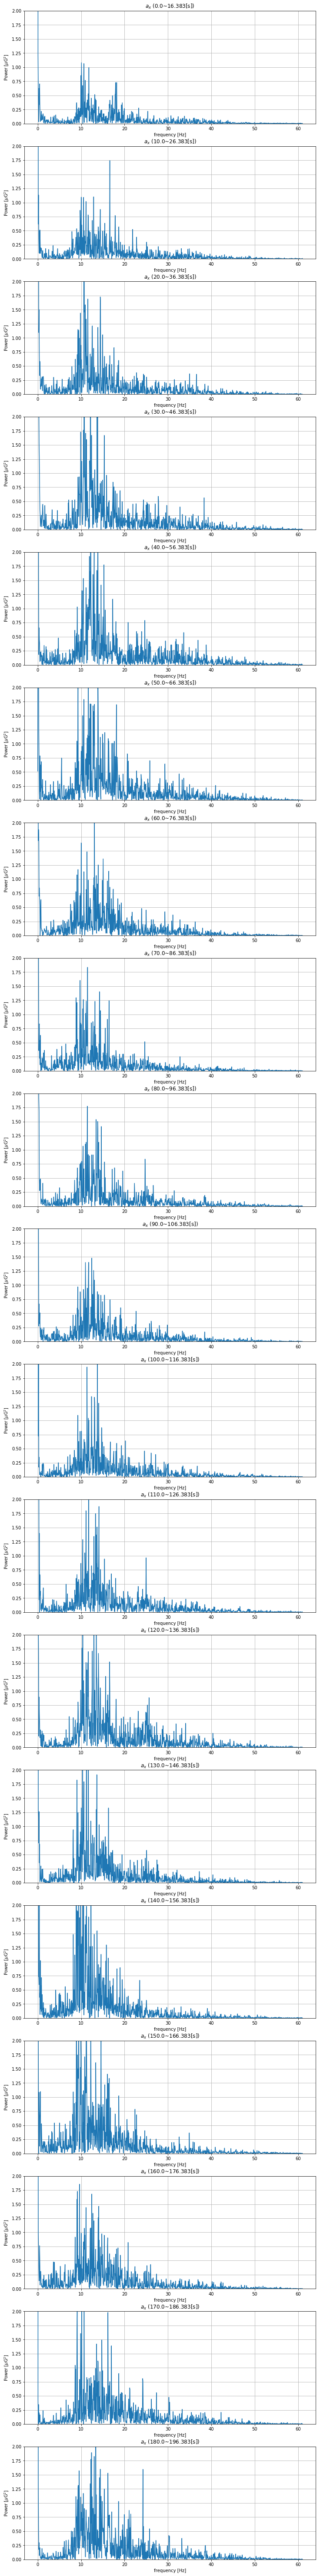

In [133]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_x[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(len(lis), 1, j)
    plt.plot(freq_arr[:1000], abs(F_a_)[:1000]**2)
    plt.ylim([0, 2])
    plt.title(f'$a_x$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

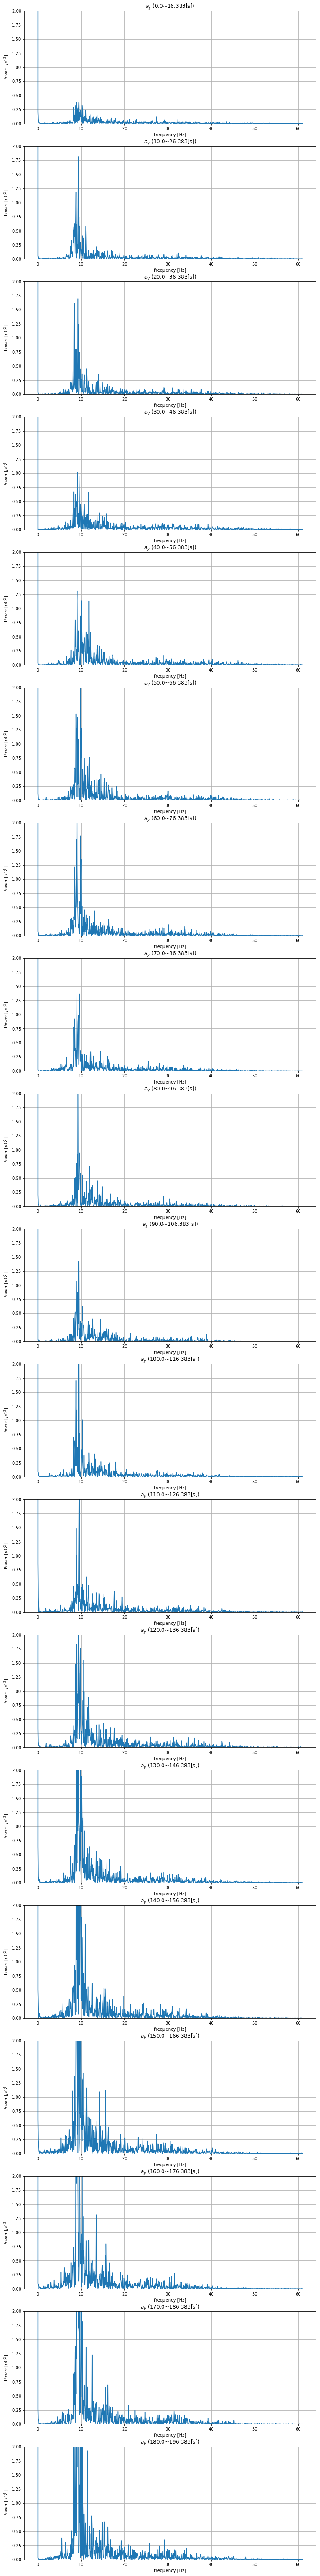

In [134]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_y[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(len(lis), 1, j)
    plt.plot(freq_arr[:1000], abs(F_a_)[:1000]**2)
    plt.ylim([0, 2])
    plt.title(f'$a_y$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1

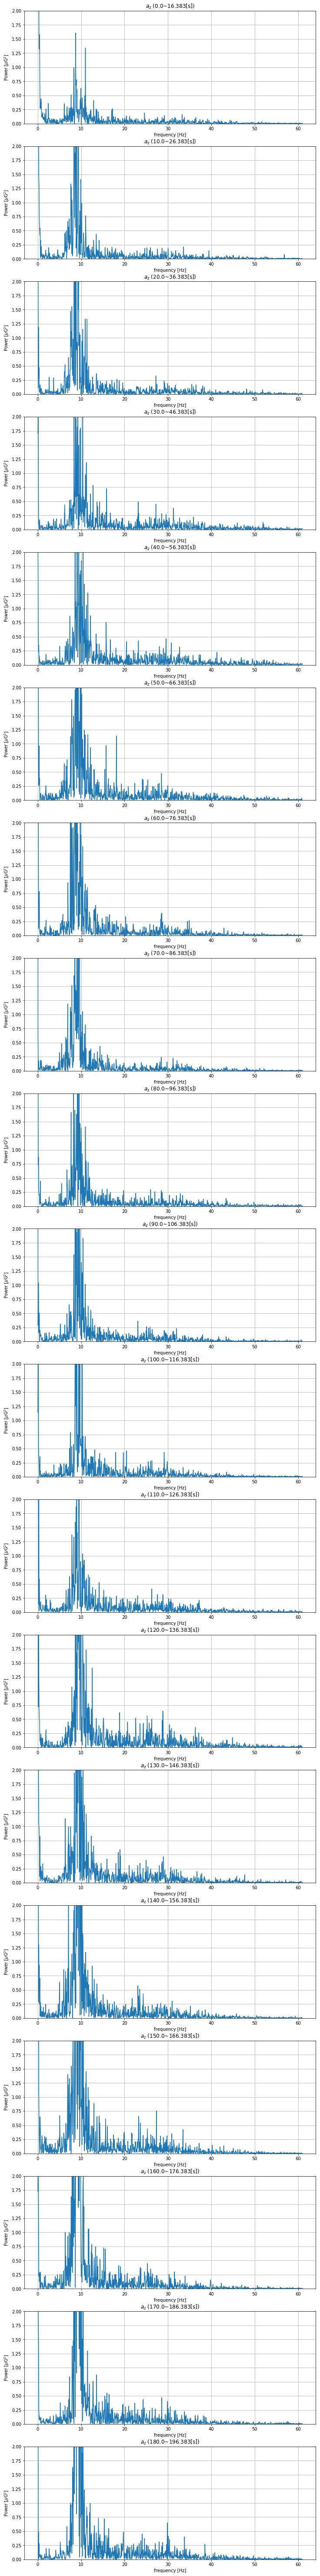

In [135]:
j = 1
plt.figure(figsize=(12,6*18))
for i in lis:
    F_a_ = np.fft.fft(a_z[i[0]:i[1]])/(i[1]-i[0])
    plt.subplot(len(lis), 1, j)
    plt.plot(freq_arr[:1000], abs(F_a_)[:1000]**2)
    plt.ylim([0, 2])
    plt.title(f'$a_z$ ({i[0]/1000}~{(i[1]-1)/1000}[s])')
    plt.xlabel('frequency [Hz]')
    plt.ylabel('Power [$\mu \mathrm{G}^2$]')
    plt.grid()
    #plt.show()
    j += 1